<a href="https://colab.research.google.com/github/jxc0229/newGitTest/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

import torch
print(torch.__version__)
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import HRNet
import utils

1.3.0


In [ ]:
#!pip install torch==1.3.0 torchvision==0.4.1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(device)
print('------------------------------------------------------------------')

In [ ]:
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
print(VGG)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

In [ ]:
style_net = HRNet.HRNet()
style_net.to(device)
print(style_net)

In [132]:
content_image = utils.load_image("/content/game_data/20073.jpg", img_size=500)  # temporary/content.png
content_image = content_image.to(device)

style_image = utils.load_image("/content/style/style_city.png")  # temporary/style.png
style_image = style_image.to(device)

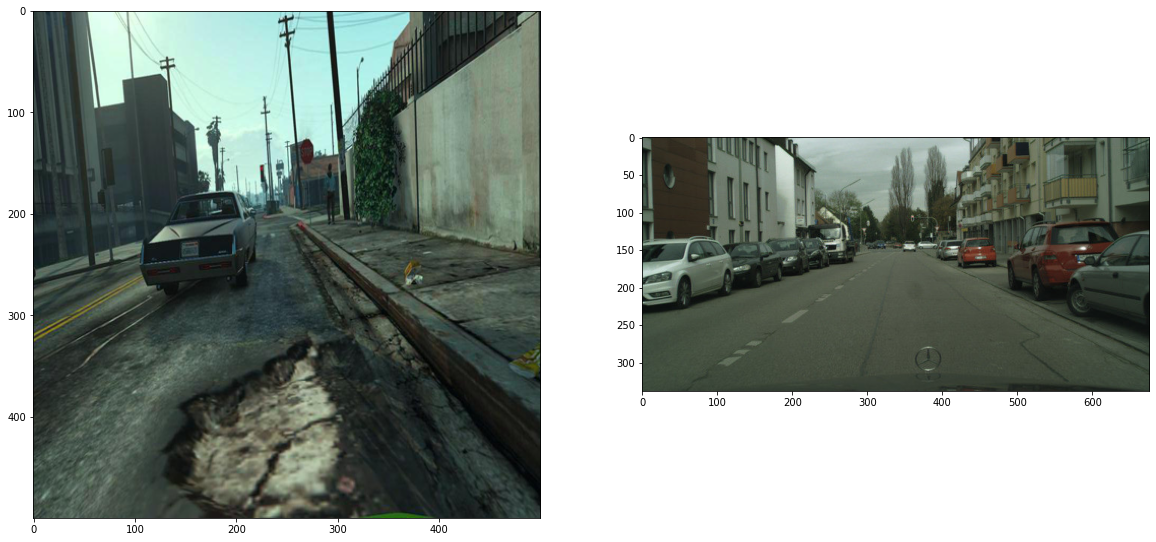

In [133]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
plt.show()

In [134]:
content_features = utils.get_features(content_image, VGG)
style_features   = utils.get_features(style_image, VGG)

style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to(device)

In [135]:
# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = 150
style_weight = 1



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


After 0 criterions:
Total loss:  93465.515625
Content loss:  7.2695488929748535
Style loss:  92375.0859375


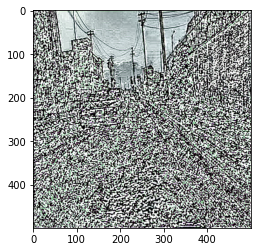

After 100 criterions:
Total loss:  420.4053955078125
Content loss:  2.6384880542755127
Style loss:  24.632200241088867


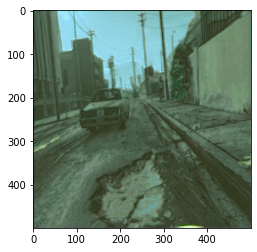

After 200 criterions:
Total loss:  188.79795837402344
Content loss:  1.1442594528198242
Style loss:  17.159042358398438


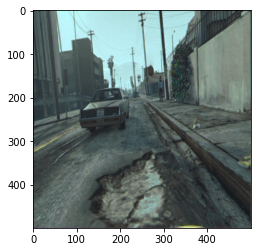

After 300 criterions:
Total loss:  122.50521850585938
Content loss:  0.710460901260376
Style loss:  15.936080932617188


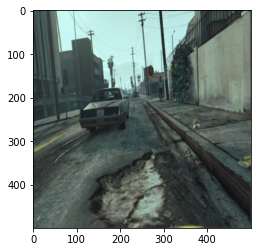

After 400 criterions:
Total loss:  90.21316528320312
Content loss:  0.4946438670158386
Style loss:  16.016584396362305


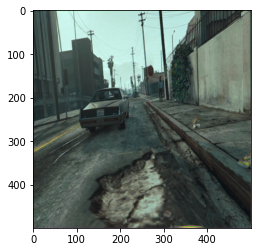

After 500 criterions:
Total loss:  74.34417724609375
Content loss:  0.38764122128486633
Style loss:  16.197994232177734


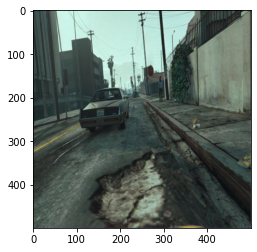

totally cost 185.98664808273315


In [136]:
show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
steps = 500

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_image
time_start=time.time()
for epoch in range(0, steps+1):
    
    scheduler.step()

    target = style_net(content_image).to(device)
    target.requires_grad_(True)


    target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)
    

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss)

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss)

    optimizer.zero_grad()
    torch.autograd.set_detect_anomaly(True)
    total_loss.backward()
    optimizer.step()

    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(utils.im_convert(target))
        plt.show()
        #save_samples(epoch, fixed_latent, show=False)

    output_image = target
time_end=time.time()
print('totally cost', time_end - time_start)

In [137]:
def to_numpy(tensor_lst):
  result = []
  for t in tensor_lst:
    result.append(t.cpu().data.numpy())
  return result

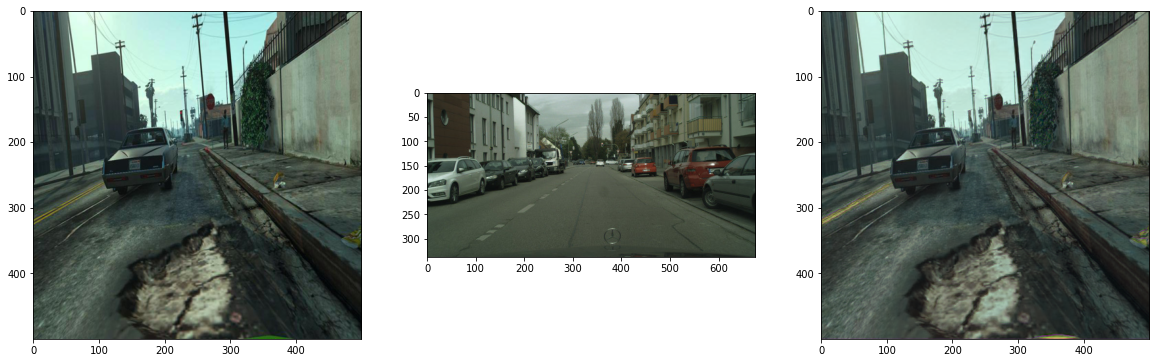

In [138]:
# display the raw images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
ax3.imshow(utils.im_convert(output_image))
plt.show()

In [139]:
# #plot the line chart
# import torch.tensor as tn 

# epoch = range(0, len(total_loss_epoch))
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10)) 

# total_loss_epoch = to_numpy(total_loss_epoch)
# style_loss_epoch = to_numpy(style_loss_epoch)
# content_loss_epoch = to_numpy(content_loss_epoch)


# ax1.plot(epoch, total_loss_epoch)
# ax1.set_title("Total loss")
# ax1.set_xlabel("epoch")
# ax1.set_ylabel("Total loss")

# ax2.plot(epoch, style_loss_epoch)
# ax2.set_title("Style loss")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("Style loss")

# ax3.plot(epoch, content_loss_epoch)
# ax3.set_title("Content loss")
# ax3.set_xlabel("epoch")
# ax3.set_ylabel("Content loss")


# plt.show()

In [140]:
# from torchvision.utils import save_image
# import os
# import cv2
# sample_dir = 'generated'
# os.makedirs(sample_dir, exist_ok=True)

# def save_samples(index):
#     fake_images = output_image
#     fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
#     print('Saving', fake_fname)

# path1 = '/content/generated'
# cv2.imwrite(os.path.join(path1 , '1.png'), output_image)
# #cv2.waitKey(0)

In [141]:
# stats = (0.229, 0.224, 0.225), (0.485, 0.456, 0.406)
# def denorm(img_tensors):
#     return img_tensors * stats[1][0] + stats[0][0]

In [142]:
#print(type(denorm(output_image)))

In [143]:
# save_image(denorm(output_image), '1.jpg')

In [144]:
# import cv2
# import os

# vid_fname = 'gans_training.avi'

# files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
# files.sort()

# out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
# [out.write(cv2.imread(fname)) for fname in files]
# out.release()